# Attempting to Build my own C-VAE for Tabular data
**This tests whether I can get the cVAE to work on Tabular data**.

Based off of the following links:
- https://github.com/abidlabs/contrastive_vae/blob/master/vae_utils.py

## Loading Packages

In [1]:
#Loading the packages 
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn import preprocessing

# Extra libraries I needed
import os
import importlib.util
import sys
import matplotlib.pyplot as plt
import math

In [2]:
# Loading the imbalanced dataset package
os.chdir("imbalanced_databases")
spec = importlib.util.spec_from_file_location("imbalanced_databases", "imbalanced_databases\\__init__.py")
foo = importlib.util.module_from_spec(spec)
sys.modules["data", "_imbalanced_databases"] = foo
spec.loader.exec_module(foo)

import imbalanced_databases as imbd

## Loading in Training/Testing Data for Pima

In [3]:
#Loadin' in Pima
data = imbd.load_iris0()
X = data['data']
y = data['target']

In [4]:
# Makin' it a DataFrame
X = pd.DataFrame(X)
X = (X - X.min()) / (X.max() - X.min())
X = np.asarray(X)
#X.head()

In [5]:
X.shape

(150, 4)

In [6]:
dim = X.shape[1]

## This is an attempt at making the C-VAutoencoder

Originally made in Keras. I will attempt to transfer this to PyTorch.


In [129]:
class Encoder(nn.Module):
    def __init__(self, input_dimensions, H = 256, H2 = 128, latent_dim = 64):
        super(Encoder, self).__init__()
        #First layer
        self.linear1=nn.Linear(input_dimensions,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features = H)
        #Second Layer
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features = H2)
        #Third Layer
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features = H2)
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)
        
        self.relu = nn.LeakyReLU()
        
    def encode(self, x):
        #print(x.shape)
        #print(x)
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        fc1 = F.relu(self.bn1(self.fc1(lin3)))
        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        return r1, r2
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        return mu, logvar
        
class Decoder(nn.Module):
    def __init__(self, input_dimensions, H = 256, H2 = 128, latent_dim = 64):
        super(Decoder, self).__init__()
        # Sampling vector
        self.fc3 = nn.Linear(latent_dim*2, latent_dim*2)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim*2)
        self.fc4 = nn.Linear(latent_dim*2, H2*2)
        self.fc_bn4 = nn.BatchNorm1d(H2*2)
        # Decoder
        self.linear4=nn.Linear(H2*2,H2*2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2*2)
        self.linear5=nn.Linear(H2*2,H*2)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H*2)
        self.linear6=nn.Linear(H*2,input_dimensions)
        self.lin_bn6 = nn.BatchNorm1d(num_features=input_dimensions)
        
        self.relu = nn.LeakyReLU()
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))
        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
    
    def forward(self, x):
        #@print(x)
        return self.decode(x)
    
    

class CVAE(nn.Module):
    def __init__(self, input_dimensions, H = 25, H2 = 9, latent_dim = 3):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.shared_encoder = Encoder(input_dimensions, H, H2, latent_dim)
        self.salient_encoder = Encoder(input_dimensions, H, H2, latent_dim)
        self.decoder = Decoder(input_dimensions, H, H2, latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

        #std = logvar.mul(0.5).exp_()
        #eps = Variable(std.data.new(std.size()).normal_())
        #return eps.mul(std).add_(mu)
        
    def forward(self, x, foreground = True):
        if foreground:
            mu_z, logvar_z = self.shared_encoder(x)
            mu_s, logvar_s = self.salient_encoder(x)
        else:
            mu_z, logvar_z = self.shared_encoder(x)
            mu_s, logvar_s = torch.zeros(x.shape[0], self.latent_dim), torch.zeros(x.shape[0], self.latent_dim)
        #print(foreground)
        #print(mu_s)
        #print(mu_z)
        mu, logvar = torch.cat((mu_s, mu_z), dim = 1), torch.cat((logvar_s, logvar_z), dim = 1)
        z = self.reparameterize(mu, logvar)
        #print(z.detach().numpy())
        return self.decoder(z), mu_s, mu_z, logvar_s, logvar_z, mu, logvar
        
        
        

### Making Sure it works and Takes in Input

In [130]:
model = CVAE(dim, 8, 4, 2)
model.eval()

CVAE(
  (shared_encoder): Encoder(
    (linear1): Linear(in_features=4, out_features=8, bias=True)
    (lin_bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=8, out_features=4, bias=True)
    (lin_bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3): Linear(in_features=4, out_features=4, bias=True)
    (lin_bn3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=4, out_features=2, bias=True)
    (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc21): Linear(in_features=2, out_features=2, bias=True)
    (fc22): Linear(in_features=2, out_features=2, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (salient_encoder): Encoder(
    (linear1): Linear(in_features=4, out_features=8, bias=True)
    (lin_bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_runn

In [131]:
# For foreground data
test = torch.from_numpy(X[0])
test = test.float()
test = test.unsqueeze(0)
recon, mu_s, mu_z, logvar_s, logvar_z, mu, logvar = model(test)

In [132]:
# For background Data
test = torch.from_numpy(X[0])
test = test.float()
test = test.unsqueeze(0)
recon, mu_s, mu_z, logvar_s, logvar_z, mu, logvar = model(test, False)

In [133]:
#They work, thank the lord

## The Dreaded Loss Function
The code below is what they wrote for their loss function.

reconstruction_loss = tf.keras.losses.mse(tg_inputs, tg_outputs)

reconstruction_loss += tf.keras.losses.mse(bg_inputs, bg_outputs)

reconstruction_loss *= input_dim



kl_loss = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)

kl_loss += 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)

kl_loss += 1 + bg_s_log_var - tf.keras.backend.square(bg_s_mean) - tf.keras.backend.exp(bg_s_log_var)

kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)

kl_loss *= -0.5

### What this means (step-by-step)
They first find the mean squared error of the target and background inputs, multiplying them by the input dimensions (*eg if we use Iris --> 4*)

They then find the kl_loss of the:

    - foreground data irrelevant
    - foreground data salient
    - background data irrelevent
They then multiply it by -0.5.

They add these (MSE and KL) together.


**Note: this does not account for disentanglement --> How they determine the salient and irrelevant features are independent**

**I will do disentanglement later**





In [134]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, target_recon, target, bg_recon, bg, tg_z_mu, tg_z_logvar, tg_s_mu, tg_s_logvar, bg_z_mu, bg_z_logvar):
        #reconstruction loss
        loss_MSE = self.mse_loss(target_recon, target)
        loss_MSE += self.mse_loss(bg_recon, bg)
        #loss_MSE *= 4
        #KL Loss
        kl_loss = torch.sum(1 + tg_z_logvar - tg_z_mu.pow(2) - tg_z_logvar.exp())
        kl_loss += torch.sum(1 + tg_s_logvar - tg_s_mu.pow(2) - tg_s_logvar.exp())
        kl_loss += torch.sum(1 + bg_z_logvar - bg_z_mu.pow(2) - bg_z_logvar.exp())
        kl_loss *= -0.5
        
        discriminator = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
        nn.Sigmoid()
        )

        
        tg_z = torch.cat([tg_z_mu, tg_z_logvar])
        tg_s = torch.cat([tg_s_mu, tg_s_logvar])
        
        batch_size = tg_z.size(0)

        # Split the tensors
        
        
        z1 = tg_z[:batch_size//2, :]
        z2 = tg_z[batch_size//2:, :]
        s1 = tg_s[:batch_size//2, :]
        s2 = tg_s[batch_size//2:, :]

        # Concatenate tensors
        q_bar = torch.cat((torch.cat((s1, z2), dim=1), torch.cat((s2, z1), dim=1)), dim=0)
        q = torch.cat((torch.cat((s1, z1), dim=1), torch.cat((s2, z2), dim=1)), dim=0)

        # Pass through the discriminator
        q_bar_score = discriminator(q_bar)
        q_score = discriminator(q)

        # Compute losses
        tc_loss = torch.log(q_score / (1 - q_score))
        discriminator_loss = -torch.log(q_score) - torch.log(1 - q_bar_score)
        #print(tc_loss)
        tc_loss = torch.sum(tc_loss)
        discriminator_loss = torch.sum(discriminator_loss)

        return loss_MSE + kl_loss + 1 * tc_loss + discriminator_loss

In [214]:
loss_function = customLoss()
model = CVAE(dim, 8, 4, 2)

In [215]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1, weight_decay = 0)

## Making Data

In [216]:
# Split Data in Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 36)

In [217]:
# Making Foreground and Background Data
# Foreground --> 1 Label (minority)
mask = y_train == 1
tg_x_train = X_train[mask]
tg_y = y_train[mask]
bg_x_train = X_train[~mask]
bg_y = y_train[~mask]

In [218]:
class DataBuilder(Dataset):
    def __init__(self, df):
        self.x = torch.from_numpy(df)
        self.len = len(df)
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [219]:
foreground_data = DataBuilder(tg_x_train)
background_data = DataBuilder(bg_x_train)

In [220]:
foreground_loader = torch.utils.data.DataLoader(dataset = foreground_data, batch_size = 2, shuffle = True, drop_last = True)
background_loader = torch.utils.data.DataLoader(dataset = background_data, batch_size = 2, shuffle = True, drop_last = True)

In [221]:
epochs = 5
log_interval = 1000
val_losses = []
train_losses = []
test_losses = []

In [222]:
def train(epoch):
    model.train()
    train_loss = 0
    for tg, bg in zip(foreground_loader, background_loader):
        tg = tg.float()
        bg = bg.float()
        optimizer.zero_grad()
        recon_tg, tg_mu_s, tg_mu_z, tg_logvar_s, tg_logvar_z, mu, logvar = model(tg)
        recon_bg, bg_mu_s, bg_mu_z, bg_logvar_s, bg_logvar_z, mu, logvar = model(bg, False)
        loss = loss_function(recon_tg, tg, recon_bg, bg, tg_mu_z, tg_logvar_z, tg_mu_s, tg_logvar_s, bg_mu_z, bg_mu_s)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 1 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(foreground_loader.dataset)))
        train_losses.append(train_loss / len(foreground_loader.dataset))
    

In [223]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 1 Average training loss: 5.7181
====> Epoch: 2 Average training loss: 3.6499
====> Epoch: 3 Average training loss: 3.3236
====> Epoch: 4 Average training loss: 3.4080
====> Epoch: 5 Average training loss: 3.5065


In [224]:
model = model.eval()

In [225]:
gen = sum(~mask) - sum(mask)

In [250]:
new_data = []
with torch.no_grad():
    for i in range(gen):
        mu_s = torch.empty(2).normal_(mean = 0, std = 5).unsqueeze(0)
        mu_z = torch.zeros(2).unsqueeze(0) #.normal(mean = 0, std = 1).unsqueeze(0)
        mu = torch.cat((mu_s, mu_z), 1)
        #print(mu)
        #mu = torch.empty(6).normal_(mean=0,std=100).unsqueeze(0)
        row = model.decoder.decode(mu)
        new_data.append(row.detach().numpy())

In [251]:
new_data = np.asarray(new_data)
new_data = pd.DataFrame(new_data.squeeze())

## Finding Minority Test Data

In [252]:
df = pd.DataFrame(X_test)

In [253]:
new_data['Label'] = 2
df['Label'] = y_test
d = pd.concat((new_data, df))

In [254]:
import seaborn as sns

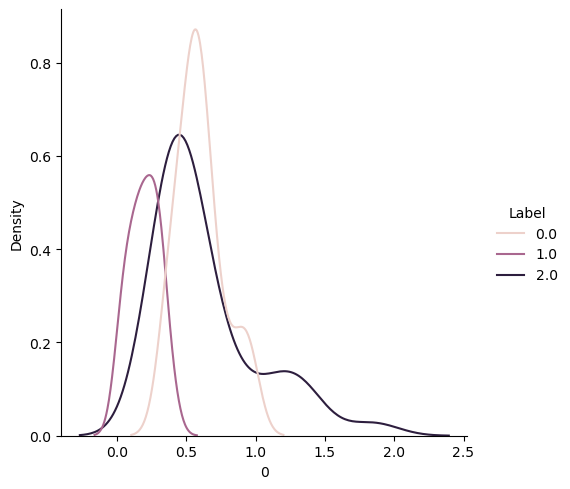

In [255]:
sns.displot(d, x=0, hue="Label", kind="kde")

In [256]:
c = {0: "black", 1: "red", 2:"green"}
colors = [c[n] for n in d['Label']]

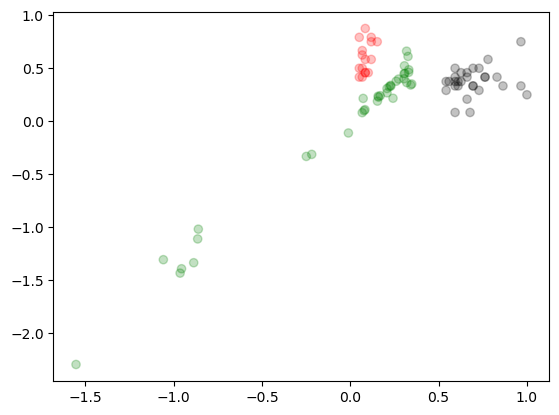

In [257]:
plt.scatter(d[2], d[1], c = colors, alpha = 0.24)

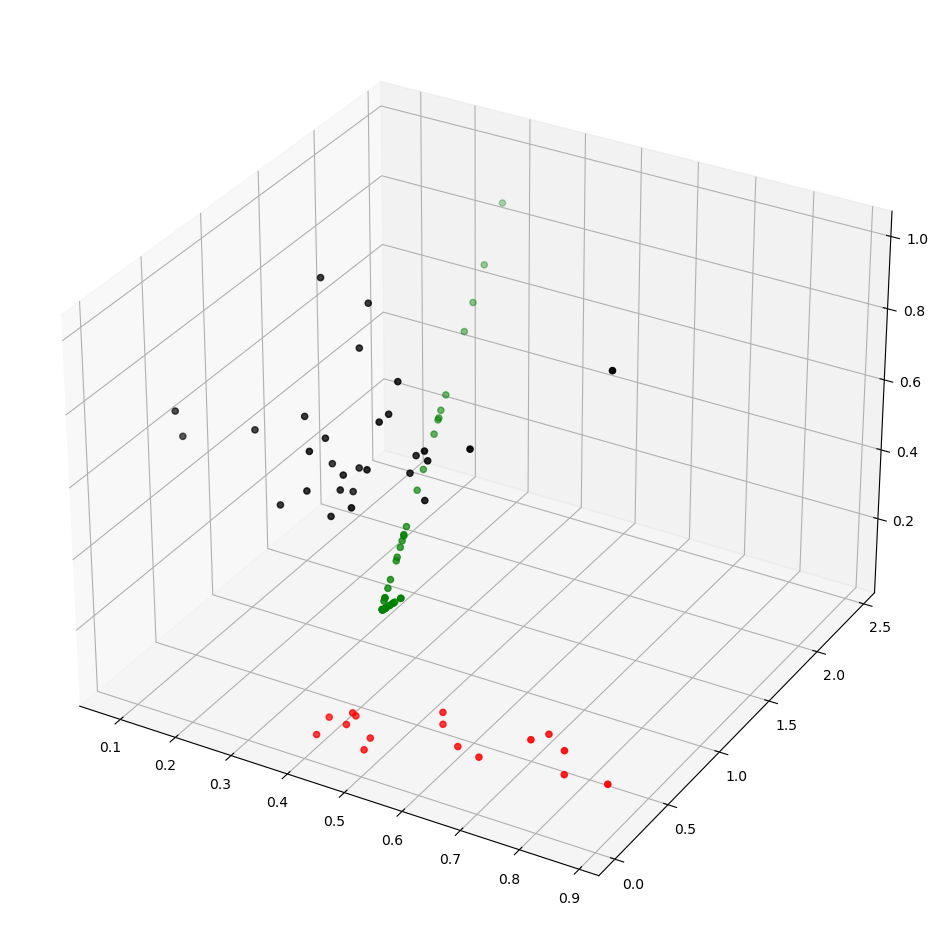

In [206]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(d[1], d[0], d[2], c = colors)

## Testing Model Performance

In [207]:
from sklearn.ensemble import RandomForestClassifier  

In [208]:
classifier= RandomForestClassifier(n_estimators= 100, criterion="entropy")  
classifier.fit(X_train, y_train)  

RandomForestClassifier(criterion='entropy')

In [209]:
# On new data
#train_augment
new_data['Label'] = 1
trainin = X_train.copy()
trainin= pd.DataFrame(trainin)
trainin['Label'] = y_train
d = pd.concat((new_data, trainin))

classifier_two= RandomForestClassifier(n_estimators= 250, criterion="entropy")  
classifier_two.fit(d.drop(["Label"], axis = 1), d["Label"])  

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [210]:
pred_before = classifier.predict(X_test)
pred_after = classifier_two.predict(X_test)

In [211]:
sum(pred_before == pred_after) / len(pred_before)

1.0

In [212]:
sum(pred_before == y_test)

45

In [213]:
sum(pred_after == y_test)

45

In [72]:
from sklearn.metrics import confusion_matrix  

Text(0.5, 1.0, 'CM for RF without Synthetic Data')

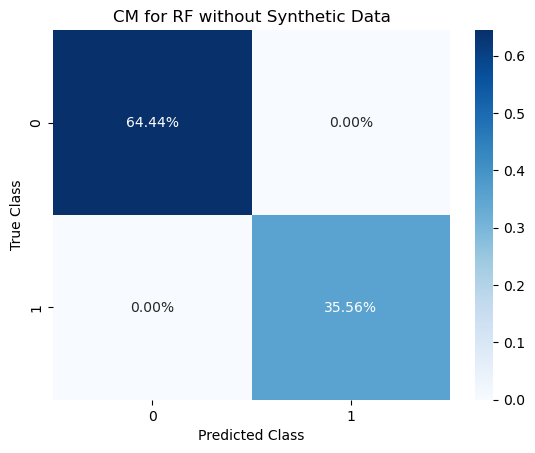

In [73]:
cm= confusion_matrix(y_test, pred_before) 
fig, ax = plt.subplots()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_title("CM for RF without Synthetic Data")


Text(0.5, 1.0, 'CM for RF with Synthetic Data')

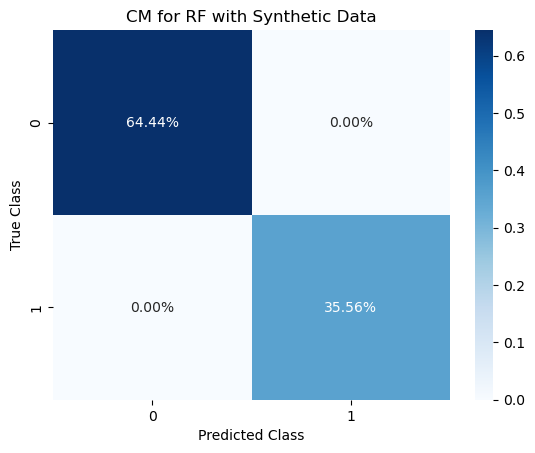

In [74]:
cm= confusion_matrix(y_test, pred_after) 
fig, ax = plt.subplots()
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_title("CM for RF with Synthetic Data")


## Encoding then Decoding

In [75]:
import random

In [236]:
interpolated = []
for i in range(35):
    idx = random.randint(0, 33)
    jdx = random.randint(0, 33)
    data_i = foreground_data.__getitem__(idx)
    data_j = foreground_data.__getitem__(jdx)   
    x = (data_i + data_j) / 2
    x = x.float()
    x = x.unsqueeze(0)
    out = model(x)
    recon = out[0]
    interpolated.append(recon.detach().squeeze().numpy())

In [143]:
interpolated = pd.DataFrame(np.asarray(interpolated))

In [144]:
interpolated.head()

,0,1,2,3
0,0.383295,0.490628,0.405016,0.349492
1,0.394565,0.492600,0.370584,0.308212
2,0.372021,0.491396,0.403406,0.341825
3,0.379871,0.494051,0.364896,0.293513
4,0.357519,0.495047,0.369655,0.285403


In [145]:
interpolated['Label'] = 2
df['Label'] = y_test
d = pd.concat((interpolated, df))

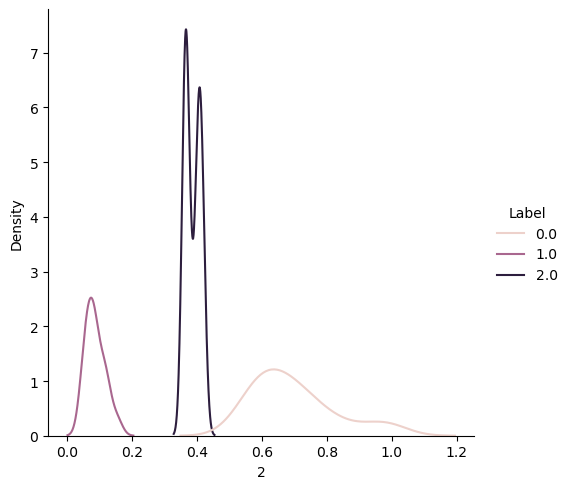

In [146]:
sns.displot(d, x=2, hue="Label", kind="kde")